In [41]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt

In [42]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [43]:

# Use only 10 images for training and testing
x_train = x_train[:10].astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train[:10], 10)
x_test = x_test[:10].astype("float32") / 255.0
y_test = tf.keras.utils.to_categorical(y_test[:10], 10)

In [44]:
# Create a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [45]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=2)


Epoch 1/10


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [7]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()



In [8]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object)


In [9]:
# Initialize C&W attack
attack = CarliniL2Method(classifier=classifier, confidence=0.0, learning_rate=0.01, binary_search_steps=5, max_iter=10)


In [10]:
# Generate adversarial examples for the test images
x_test_adv = attack.generate(x=x_test)



C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


In [11]:
# Evaluate model accuracy on adversarial examples
accuracy = np.mean(np.argmax(classifier.predict(x_test_adv), axis=1) == np.argmax(y_test, axis=1))

# Print accuracy
print(f"CIFAR-10 (10 images) C&W Attack Accuracy: {accuracy * 100:.2f}%")


CIFAR-10 (10 images) C&W Attack Accuracy: 10.00%


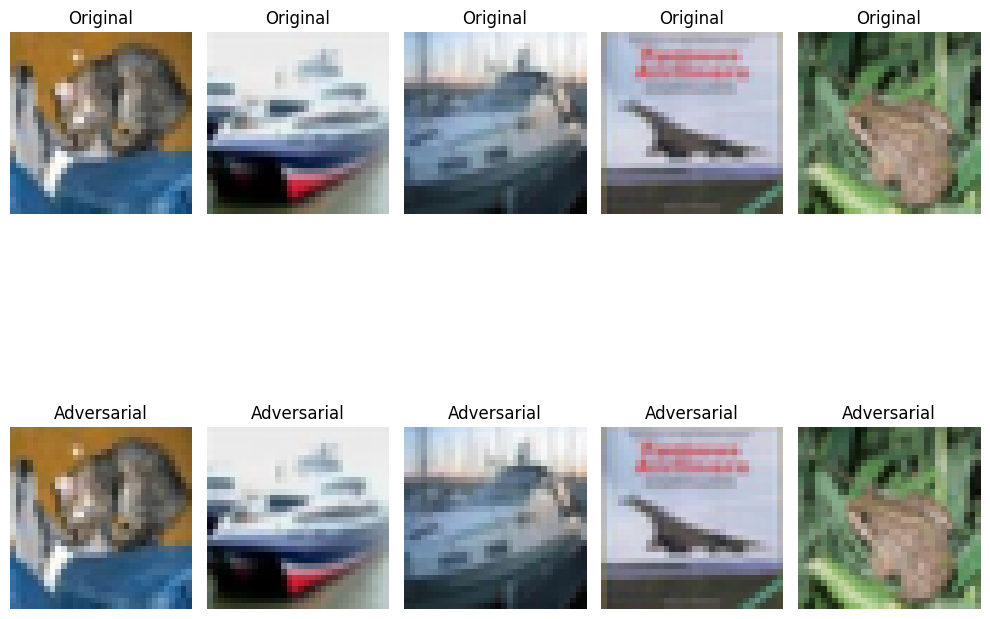

In [12]:
# Visualization function
def visualize_examples(x_test, x_adv, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(x_adv[i])
        plt.title("Adversarial")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize adversarial examples
visualize_examples(x_test, x_test_adv)

In [13]:
# Function to generate adversarial examples with different confidence levels
def generate_adversarial_examples(classifier, x_test, confidences):
    accuracies = []
    for confidence in confidences:
        attack = CarliniL2Method(classifier=classifier, confidence=confidence, learning_rate=0.01, binary_search_steps=5, max_iter=10)
        x_test_adv = attack.generate(x=x_test)
        accuracy = np.mean(np.argmax(classifier.predict(x_test_adv), axis=1) == np.argmax(y_test, axis=1))
        accuracies.append(accuracy)
    return accuracies


In [14]:
# Range of confidence levels to test
confidence_values = np.linspace(0.0, 1.0, num=5)

# Generate adversarial examples and evaluate model accuracy
accuracies = generate_adversarial_examples(classifier, x_test, confidence_values)


C&W L_2: 100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


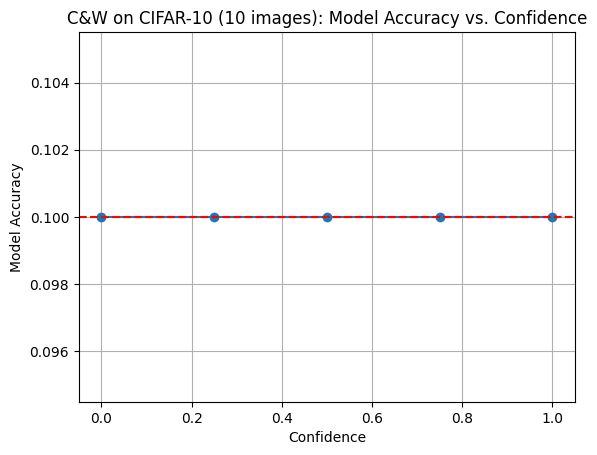

Maximum confidence value after which the model fails (accuracy <= 10%): 0.00


In [15]:
# Plot the graph
plt.plot(confidence_values, accuracies, marker="o")
plt.axhline(y=0.1, color='r', linestyle='--')
plt.xlabel("Confidence")
plt.ylabel("Model Accuracy")
plt.title("C&W on CIFAR-10 (10 images): Model Accuracy vs. Confidence")
plt.grid(True)
plt.show()

# Print the maximum confidence value after which the model fails (accuracy <= 10%)
if np.any(np.array(accuracies) <= 0.1):
    print(f"Maximum confidence value after which the model fails (accuracy <= 10%): {confidence_values[np.where(np.array(accuracies) <= 0.1)[0][0]]:.2f}")
else:
    print("The model does not fail for any confidence value in the specified range.")